# IMPORTS

In [1]:
COLAB = False

In [2]:
from pathlib import Path

if COLAB:
    %load_ext tensorboard
    !git clone https://github.com/abodinier/DCGAN-dose-prediction.git
    !pip install transformers
    !pip install torchmetrics
    import sys
    sys.path.append("./DCGAN-dose-prediction/")
    
    from google.colab import drive

    drive.mount('/content/gdrive')
    STORAGE = Path("/content/gdrive/MyDrive/dose-prediction")
else:
    STORAGE = Path("./")

In [3]:
import os
import sys
import time
import json
import datetime
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
from torch.utils.tensorboard import SummaryWriter

import torch
from torch import nn
from torchsummary import summary
from torchmetrics import Accuracy
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup

from utils import log_images
from metrics import mean_absolute_error, peak_signal_to_noise_ratio, structural_similarity_index

In [4]:
%load_ext autoreload

# CONSTANTS

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_DIR = Path("./MVA-Dose-Prediction/")
Tensor = torch.cuda.FloatTensor if DEVICE == "cuda" else torch.FloatTensor

# DATA

In [6]:
if not DATA_DIR.is_dir():
    !git clone https://github.com/soniamartinot/MVA-Dose-Prediction.git

## Visualize data images

In [7]:
def plot_sample(sample_folder_path):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(np.swapaxes(np.load(sample_folder_path/'ct.npy'), 0, 1),
              cmap='gray', origin='lower')
    plt.title("CT")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(np.swapaxes(np.load(sample_folder_path/'possible_dose_mask.npy'), 0, 1),
              cmap='gray', origin='lower')
    plt.title("Possible dose mask")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(np.swapaxes(np.load(sample_folder_path/'structure_masks.npy').sum(axis=0), 0, 1),
              cmap='gray', origin='lower')
    plt.title("Structure masks")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(np.swapaxes(np.load(sample_folder_path/'dose.npy'), 0, 1),
              cmap='gray', origin='lower')
    plt.title("Dose")
    plt.axis('off')
    plt.show()

<Figure size 1080x720 with 0 Axes>

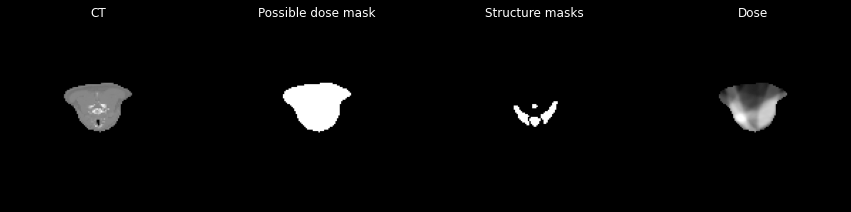

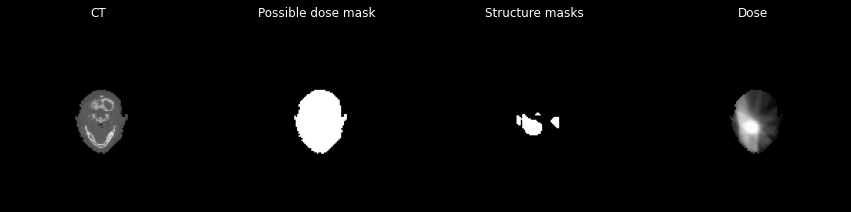

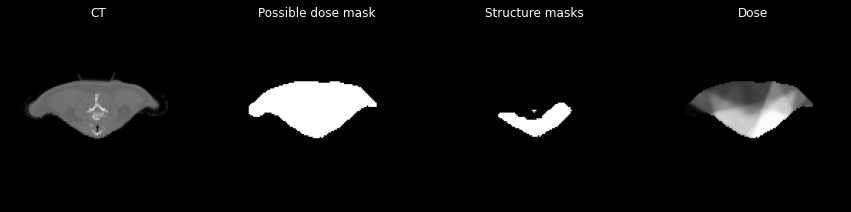

In [8]:
all_train_samples = list((DATA_DIR/"train").iterdir())
n_train_samples = len(all_train_samples)

plt.figure(figsize=(15, 10))

for i in np.random.choice(np.arange(0, n_train_samples), 3):
  path = all_train_samples[i]
  plot_sample(path)

## Dataset

In [9]:
class DoseDataset(torch.utils.data.Dataset):
    def __init__(self, root, mode="train"):

        self.files = sorted((root/mode).iterdir())
        self.mode = mode

    def __getitem__(self, index):
        img = np.vstack(
            (
                np.load(self.files[index]/"ct.npy")[np.newaxis, :, :],
                np.load(self.files[index]/"structure_masks.npy")
            )
        )
        return {
            "ct": np.load(self.files[index]/"ct.npy"),
            "structure_masks": np.load(self.files[index]/"structure_masks.npy"),
            "img": img, 
            "possible_dose_mask": np.load(self.files[index]/"possible_dose_mask.npy"),
            "dose": np.load(self.files[index]/"dose.npy") if self.mode != "test" else None,
        }

    def __len__(self):
        return len(self.files)

# MODEL

## Architecture:
- Generator :
  - UNet
- Discrimintor :
  - 3 layer-CNN with a 2-layer Dense classification head

## Generator

Convolutional UNet with 5 downscale layers and 5 upscale layers

In [12]:
class Generator(nn.Module):

    def __init__(self, in_channels=11, out_channels=1):
        super(Generator, self).__init__()

        feature_maps = 32
        self.encoder1 = Generator._block(in_channels, feature_maps, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = Generator._block(feature_maps, feature_maps * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = Generator._block(feature_maps * 2, feature_maps * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = Generator._block(feature_maps * 4, feature_maps * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = Generator._block(feature_maps * 8, feature_maps * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            feature_maps * 16, feature_maps * 8, kernel_size=2, stride=2
        )
        self.decoder4 = Generator._block((feature_maps * 8) * 2, feature_maps * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            feature_maps * 8, feature_maps * 4, kernel_size=2, stride=2
        )
        self.decoder3 = Generator._block((feature_maps * 4) * 2, feature_maps * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            feature_maps * 4, feature_maps * 2, kernel_size=2, stride=2
        )
        self.decoder2 = Generator._block((feature_maps * 2) * 2, feature_maps * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            feature_maps * 2, feature_maps, kernel_size=2, stride=2
        )
        self.decoder1 = Generator._block(feature_maps * 2, feature_maps, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=feature_maps, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return self.conv(dec1)

    @staticmethod
    def _block(in_channels, feature_maps, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=feature_maps,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=feature_maps)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=feature_maps,
                            out_channels=feature_maps,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=feature_maps)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [13]:
summary(Generator().to(DEVICE), input_size=(11, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           3,168
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]           9,216
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
         MaxPool2d-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          18,432
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,864
      BatchNorm2d-12           [-1, 64, 64, 64]             128
             ReLU-13           [-1, 64, 64, 64]               0
        MaxPool2d-14           [-1, 64,

## Discriminator

In [14]:
class Discriminator(nn.Module):
    def __init__(self, dropout=0.1):
        super(Discriminator, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.LazyConv2d(128, 5, stride=2),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(128),
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(128, 256, 3, stride=2),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(256, 256, 3, stride=2),
            torch.nn.MaxPool2d(2),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(),
            
            torch.nn.Flatten(),
            torch.nn.Dropout(dropout),
            torch.nn.LazyLinear(100),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(100, 1)
        )

    def forward(self, x, labels):
        # x: the ct inputs:  [bs, 11, 128, 128]
        # labels: the dose mask:  [bs, 1, 128, 128]
        x = torch.cat((x, labels), dim=1)  # [bs, 12, 128, 128]
        return self.model(x)

# Hyper parameters

In [15]:
ALPHA = 0.5  # ALPHA = 1 => only adversarial loss, ALPHA = 0 => only L1 loss

LR_G = 1e-3
LR_D = 1e-3

N_EPOCHS = 30
BATCH_SIZE = 128

train_dataset = DoseDataset(root=DATA_DIR, mode="train_small")
test_dataset = DoseDataset(root=DATA_DIR, mode="test")
val_dataset = DoseDataset(root=DATA_DIR, mode="validation_small")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

NUM_TRAINING_STEPS = N_EPOCHS * len(train_dataloader)

hp = {
    "alpha": ALPHA,
    "lr_g": LR_G,
    "lr_d": LR_D,
    "n_epochs": N_EPOCHS,
    "batch_size": BATCH_SIZE,
    "num_training_steps": NUM_TRAINING_STEPS
}


EXP_NAME = "CNN"
TIMESTAMP = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
EXP_DIR = STORAGE/"trains"/f"{EXP_NAME}_{TIMESTAMP}"
EXP_DIR.mkdir(exist_ok=True, parents=True)

with open(EXP_DIR/'hp.json', 'w') as f: json.dump(hp, f)

logger = SummaryWriter(log_dir=EXP_DIR/"logger", comment=str(hp))

## GAN training

In [341]:
l1_criterion = torch.nn.L1Loss().to(DEVICE)
cross_entropy_loss = torch.nn.BCEWithLogitsLoss().to(DEVICE)
accuracy_fn = Accuracy(task="binary").to(DEVICE)

# Initialize the generator
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

# Optimizer
optimizerG = torch.optim.Adam(
    generator.parameters(),
    lr=LR_G,
)
lr_scheduler_g = get_linear_schedule_with_warmup(optimizer=optimizerG, num_training_steps=2 * NUM_TRAINING_STEPS, num_warmup_steps=0.1 * NUM_TRAINING_STEPS)

optimizerD = torch.optim.Adam(
    discriminator.parameters(),
    lr=LR_D,
)
lr_scheduler_d = get_linear_schedule_with_warmup(optimizer=optimizerD, num_training_steps=2 * NUM_TRAINING_STEPS, num_warmup_steps=0.1 * NUM_TRAINING_STEPS)

prev_time = time.time()

progress_bar = tqdm(total=NUM_TRAINING_STEPS)

lr_values_d = []
lr_values_g = []

for epoch in range(N_EPOCHS):
    train_l1_loss_g = []
    train_adversarial_loss_g = []
    val_l1_loss_g = []
    val_adversarial_loss_g = []
    
    train_loss_d = []
    val_loss_d = []
    train_acc_d = []
    val_acc_d = []

    for i, batch in enumerate(train_dataloader):

        img = batch["img"].type(Tensor)
        real_dose = batch["dose"].type(Tensor)
        
        # Train Discriminator
        optimizerD.zero_grad()
        
        discriminator_on_real_dose = discriminator(img, real_dose[:, None, :, :])
        pos_sample_labels = torch.ones(size=(len(real_dose), 1), device=DEVICE)
        pos_sample_preds = torch.nn.Sigmoid()(discriminator_on_real_dose)
        
        pos_samples_loss = cross_entropy_loss(
            input=discriminator_on_real_dose, target=pos_sample_labels
        )
        
        with torch.no_grad():
            generated_dose = generator(img)
        discriminator_on_generated_dose = discriminator(img, generated_dose.detach())
        neg_sample_labels = torch.zeros(size=(len(real_dose), 1), device=DEVICE)
        neg_samples_loss = cross_entropy_loss(
            input=discriminator_on_generated_dose, target=neg_sample_labels
        )
        neg_sample_preds = torch.nn.Sigmoid()(discriminator_on_generated_dose)
        
        discriminator_loss = (pos_samples_loss + neg_samples_loss) / 2
        discriminator_loss.backward()
        optimizerD.step()
        lr_values_d.append(optimizerD.param_groups[0]["lr"])
        lr_scheduler_d.step()
        
        train_loss_d.append(discriminator_loss.item())
        
        d_acc = accuracy_fn(
            torch.cat((pos_sample_preds, neg_sample_preds), dim=-1),
            torch.cat((pos_sample_labels, neg_sample_labels), dim=-1).type(torch.int)
        ).item()
        train_acc_d.append(d_acc)
        
        
        # Train Generator
        optimizerG.zero_grad()
        generated_dose = generator(img)
        generator_l1_loss = l1_criterion(
            input=generated_dose[:, 0, :, :],
            target=real_dose
        )
        discriminator_on_generated_dose = discriminator(img, generated_dose)
        generator_adversarial_loss = cross_entropy_loss(
            input=discriminator_on_generated_dose,
            target=torch.ones(size=(len(real_dose), 1), device=DEVICE)
        )
        
        generator_loss = ALPHA * generator_adversarial_loss + (1 - ALPHA) * generator_l1_loss
        generator_loss.backward()
        optimizerG.step()
        lr_values_g.append(optimizerG.param_groups[0]["lr"])
        lr_scheduler_g.step()
        
        train_l1_loss_g.append(generator_l1_loss.item())
        train_adversarial_loss_g.append(generator_adversarial_loss.item())
    
        progress_bar.update(1)
    
    logger.add_scalar(tag=f"train/discrimintor_loss", scalar_value=np.mean(train_loss_d), global_step=epoch)
    logger.add_scalar(tag=f"train/discrimintor_accuracy", scalar_value=np.mean(train_acc_d), global_step=epoch)
    logger.add_scalar(tag=f"train/generator_l1_loss", scalar_value=np.mean(train_l1_loss_g), global_step=epoch)
    logger.add_scalar(tag=f"train/generator_adversarial_loss", scalar_value=np.mean(train_adversarial_loss_g), global_step=epoch)

    for batch in DataLoader(train_dataset, batch_size=5, shuffle=True):
        fig = log_images(batch, generator, discriminator, Tensor)
        logger.add_figure(tag=f"train/image", figure=fig, global_step=epoch)
        break
    
    
    for i, batch in enumerate(val_dataloader):
        with torch.no_grad():
            img = batch["img"].type(Tensor)
            real_dose = batch["dose"].type(Tensor)

            generated_dose = generator(img)
            discriminator_on_real_dose = discriminator(img, real_dose[:, None, :, :])
            discriminator_on_generated_dose = discriminator(img, generated_dose)
            
            pos_sample_labels = torch.ones(size=(len(real_dose), 1), device=DEVICE)
            neg_sample_labels = torch.zeros(size=(len(real_dose), 1), device=DEVICE)
            pos_sample_preds = torch.nn.Sigmoid()(discriminator_on_real_dose)
            neg_sample_preds = torch.nn.Sigmoid()(discriminator_on_generated_dose)
            
            pos_samples_loss = cross_entropy_loss(
                input=discriminator_on_real_dose, target=pos_sample_labels
            )
            
            neg_samples_loss = cross_entropy_loss(
                input=discriminator_on_generated_dose, target=neg_sample_labels
            )
            
            discriminator_loss = (pos_samples_loss + neg_samples_loss) / 2
            
            val_loss_d.append(discriminator_loss.item())
            
            d_acc = accuracy_fn(
                torch.cat((pos_sample_preds, neg_sample_preds), dim=-1),
                torch.cat((pos_sample_labels, neg_sample_labels), dim=-1).type(torch.int)
            ).item()
            val_acc_d.append(d_acc)
            
            generator_l1_loss = l1_criterion(
                input=generated_dose[:, 0, :, :],
                target=real_dose
            )
            generator_adversarial_loss = cross_entropy_loss(
                input=discriminator_on_generated_dose,
                target=torch.ones(size=(len(real_dose), 1), device=DEVICE)
            )
            
            generator_loss = ALPHA * generator_adversarial_loss + (1 - ALPHA) * generator_l1_loss
            
            val_l1_loss_g.append(generator_l1_loss.item())
            val_adversarial_loss_g.append(generator_adversarial_loss.item())

    logger.add_scalar(tag=f"val/discrimintor_loss", scalar_value=np.mean(val_loss_d), global_step=epoch)
    logger.add_scalar(tag=f"val/discrimintor_accuracy", scalar_value=np.mean(val_acc_d), global_step=epoch)
    logger.add_scalar(tag=f"val/generator_l1_loss", scalar_value=np.mean(val_l1_loss_g), global_step=epoch)
    logger.add_scalar(tag=f"val/generator_adversarial_loss", scalar_value=np.mean(val_adversarial_loss_g), global_step=epoch)
    
    progress_bar.set_description(f"EPOCH [{epoch + 1}/{N_EPOCHS}]\nDiscriminator: Val Loss: {np.mean(val_loss_d):.2f}\nGenerator: Val Loss: {ALPHA * np.mean(val_l1_loss_g) + (1 - ALPHA) * np.mean(val_adversarial_loss_g):.2f}")
    
    torch.save(generator.state_dict(), EXP_DIR/"generator.pt")
    torch.save(discriminator.state_dict(), EXP_DIR/"discriminator.pt")

  0%|          | 0/30 [00:00<?, ?it/s]

# EVALUATE

In [29]:
def evaluate_generator(generator):
    """Evaluate a generator.

    Args:
        generator: (GeneratorUNet) neural network generating T2-w images

    """
    res_train, res_test = [], []

    cuda = True if torch.cuda.is_available() else False
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    with torch.no_grad():

        for i, batch in enumerate(train_dataloader):

            # Inputs T1-w and T2-w
            real_img = batch["img"].type(Tensor)
            real_dose = batch["dose"].type(Tensor)
            real_possible_dose_mask = batch["possible_dose_mask"].type(Tensor)
            fake_dose = generator(real_img)
            fake_dose = (real_possible_dose_mask*fake_dose[:, 0, :,:])

            mae = mean_absolute_error(real_dose, fake_dose).item()
            psnr = peak_signal_to_noise_ratio(real_dose, fake_dose).item()
            ssim = structural_similarity_index(real_dose, fake_dose).item()

            res_train.append([mae, psnr, ssim])

        for i, batch in enumerate(val_dataloader):

            # Inputs T1-w and T2-w
            real_img = batch["img"].type(Tensor)
            real_dose = batch["dose"].type(Tensor)
            real_possible_dose_mask = batch["possible_dose_mask"].type(Tensor)
            fake_dose = generator(real_img)
            fake_dose = (real_possible_dose_mask*fake_dose[:, 0, :,:])

            mae = mean_absolute_error(real_dose, fake_dose).item()
            psnr = peak_signal_to_noise_ratio(real_dose, fake_dose).item()
            ssim = structural_similarity_index(real_dose, fake_dose).item()

            res_test.append([mae, psnr, ssim])

        df = pd.DataFrame([
            pd.DataFrame(res_train, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze(),
            pd.DataFrame(res_test, columns=['MAE', 'PSNR', 'SSIM']).mean().squeeze()
        ], index=['Training set', 'Test set']).T
    return df

In [30]:
df = evaluate_generator(generator)

In [31]:
df

,Training set,Test set
MAE,3.633956,2.577026
PSNR,-22.108870,-19.623777
SSIM,0.032824,0.057043
